# Fisher Information

Autodiff doesn't just make it faster to solve optimization and inference problems - it also allows you to use powerful ideas in statistics that require second derivatives that are intractable analytically or with finite differences.

The Fisher Information Matrix, or the inverse of the Hessian of the likelihood, can be used for
- the [Laplace approximation](https://www.sciencedirect.com/topics/mathematics/laplace-approximation) to a posterior for variational inference, giving you the Gaussian covariance of the posterior near the maximum likelihood point;
- Fisher forecasting, where you calculate this for an instrument or experiment at expected parameters, to predict how well it will constrain them; and
- optimal design, as the [Cramér-Rao lower bound](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93Rao_bound) on the precision of an experiment is the inverse of the Fisher information matrix - so you want to make this as tight as possible!

Because `jax` lets us compute the Hessian of our loss function, we can use the Fisher matrix for variational inference without MCMC, and also more powerfully _as an objective function_ to optimize a telescope design: why bother engineering a PSF for a particular goal, when you could model the system _end to end_ and optimize the precision of the Fisher forecast of the parameter of interest?

* This is the topic of a Desdoigts et al paper in prep. It wasn't quite that easy to build and we're pretty happy about it.

This notebook follows on from [Phase Mask Design](designing_a_mask.ipynb) and will reuse some of the same code without repeating explanations.

Right, let's import some things.

In [1]:
# Core jax
import jax
from jax.config import config

import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu

# # Bayesan functions
# from dLux.utils import bayes

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from chainconsumer import ChainConsumer

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

First we construct our parameterised Binary Source

In [2]:
separation = dlu.arcsec_to_rad(10)
wavels = 1e-9 * np.linspace(595, 695, 3)
source = dl.BinarySource(separation=separation, position_angle=np.pi/2, 
                         flux=1e6, contrast=1, wavelengths=wavels)

Here we want to optimise a binary mask using the CLIMB algorithm using the saved basis vectors from the tutorial on [designing a mask](../designing_a_mask.ipynb). 

We can use the pre-built Toliman model, while adding our CLIMB mask.

In [3]:
# Binary CLIMB mask basis
climb_basis = np.load("files/basis.npy")
coefficients = 100*jr.normal(jr.PRNGKey(0), [len(climb_basis)])
mask_layer = dl.models.toliman.ApplyBasisCLIMB(climb_basis, wavels.mean(), coefficients)


# optics = dl.models.TolimanOptics(psf_npixels=256, mask=mask_layer)

# # optics = dl.utils.toliman(wavefront_npixels   = 256,
# #                           detector_npixels    = 256,
# #                           detector_pixel_size = 0.2,
# #                           nzernike            = 7,
# #                           extra_layers        = [mask_layer])

# # Construct instrument
# model = dl.Instrument(optics, source)

optics = dl.models.TolimanOptics(psf_npixels=200, mask=mask_layer, zernikes=np.arange(4, 11), amplitude=1e-9)
source = dl.models.toliman.AlphaCen()
model = dl.models.Toliman(optics, source)

Visualize the PSF:

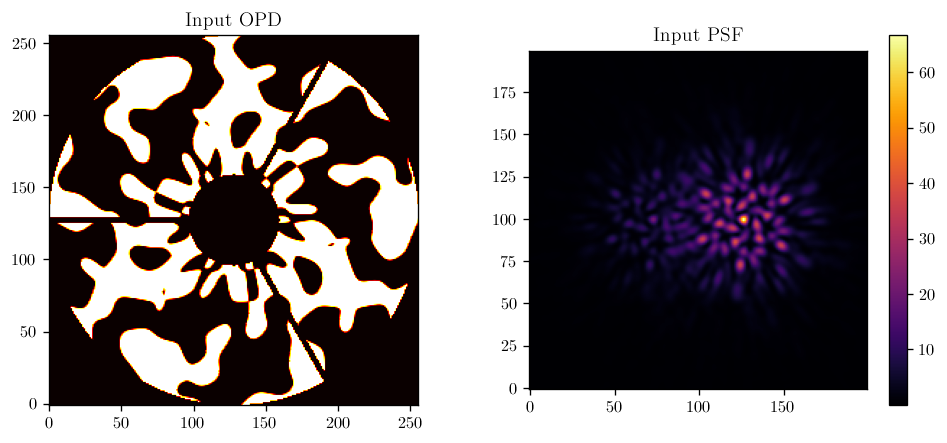

In [6]:
aperture = model.aperture.transmission
mask = model.mask.get_binary_phase()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(aperture * mask, cmap='hot')
plt.title('Input OPD')

plt.subplot(1, 2, 2)
psf = model.model()
plt.imshow(psf)
plt.colorbar()
plt.title('Input PSF')
plt.show()

In [8]:
loglike_fn = zdx.bayes.poiss_loglike
shape_dict = {'wavelengths': (1,)}
opt_param = 'mask.coefficients'
marginal_params = ['separation', 'contrast', 'position_angle', 'wavelengths', 
    'psf_pixel_scale', 'aperture.coefficients']

@zdx.filter_jit
@zdx.filter_value_and_grad(opt_param)
def fim_loss_func(model, parameters):
    cov = zdx.self_covariance_matrix(model, parameters, loglike_fn, 
        shape_dict=shape_dict)
    return zdx.covaraince_entropy(cov)

Call the loss function once to compile:

In [9]:
%%time
loss, grads = fim_loss_func(model, marginal_params)
print("Initial Loss: {}".format(loss))

Initial Loss: -192.1590118408203
CPU times: user 18.6 s, sys: 682 ms, total: 19.3 s
Wall time: 10.6 s


Now run gradient descent!

In [10]:
optim, opt_state = zdx.get_optimiser(model, opt_param, optax.adam(2e1))

losses, models_out = [], [model]
with tqdm(range(50),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = fim_loss_func(model, marginal_params)
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)
        models_out.append(model)
        losses.append(loss)
        t.set_description("Loss: {:.3f}".format(loss)) # update the progress bar

Gradient Descent:   0%|          | 0/50 [00:00<?, ?it/s]

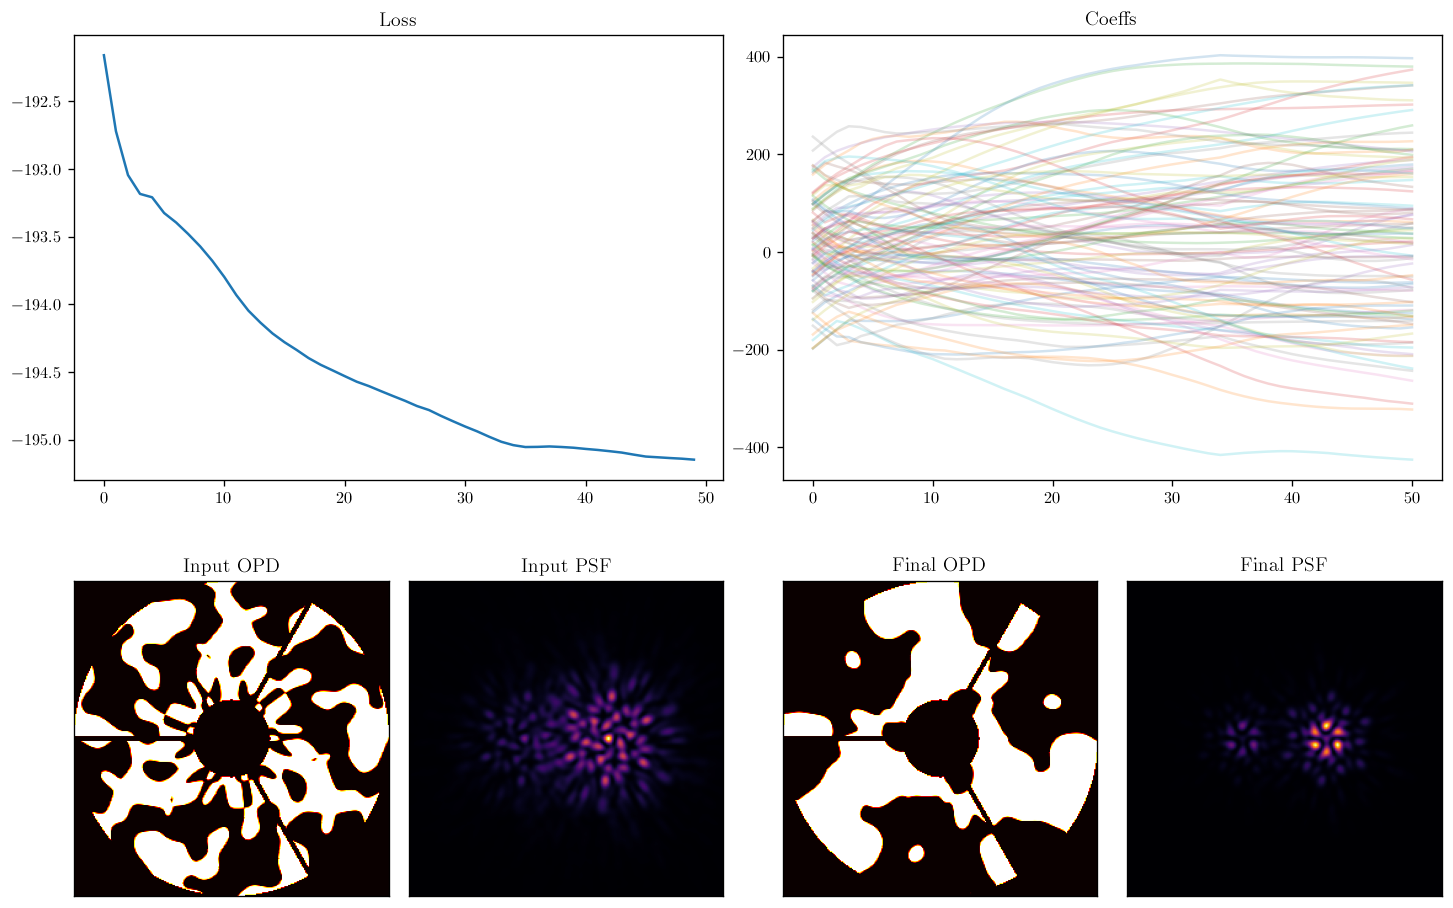

In [11]:
coeffs_out = np.array([model.get(opt_param) for model in models_out])

mosaic = """
         AABB
         CDEF
         """

fig = plt.figure(constrained_layout=True,figsize=(12, 8))
axes = fig.subplot_mosaic(mosaic)

for ax in ['C','D','E','F']:
    axes[ax].set_xticks([])
    axes[ax].set_yticks([])


axes['A'].plot(np.array(losses))
axes['A'].set_title("Loss")

axes['B'].set_title("Coeffs")
axes['B'].plot(coeffs_out[:], alpha=0.2)

mask = models_out[0].mask.get_binary_phase()
axes['C'].imshow(aperture * mask, cmap='hot')
axes['C'].set_title('Input OPD')

psf_in = models_out[0].model()
axes['D'].imshow(psf_in)
axes['D'].set_title('Input PSF')

mask = models_out[-1].mask.get_binary_phase()
axes['E'].imshow(aperture * mask, cmap='hot')
axes['E'].set_title('Final OPD')

psf_out = models_out[-1].model()
axes['F'].imshow(psf_out)
axes['F'].set_title('Final PSF')

plt.show()

Let's calculate the covariance matrix elements:

In [12]:
%%time
covs = [zdx.self_covariance_matrix(model, marginal_params, loglike_fn, 
        shape_dict=shape_dict) for model in [models_out[0], models_out[-1]]]

CPU times: user 13.5 s, sys: 913 ms, total: 14.4 s
Wall time: 6.1 s


And using [ChainConsumer](https://samreay.github.io/ChainConsumer/) we can easily visualize this covariance:

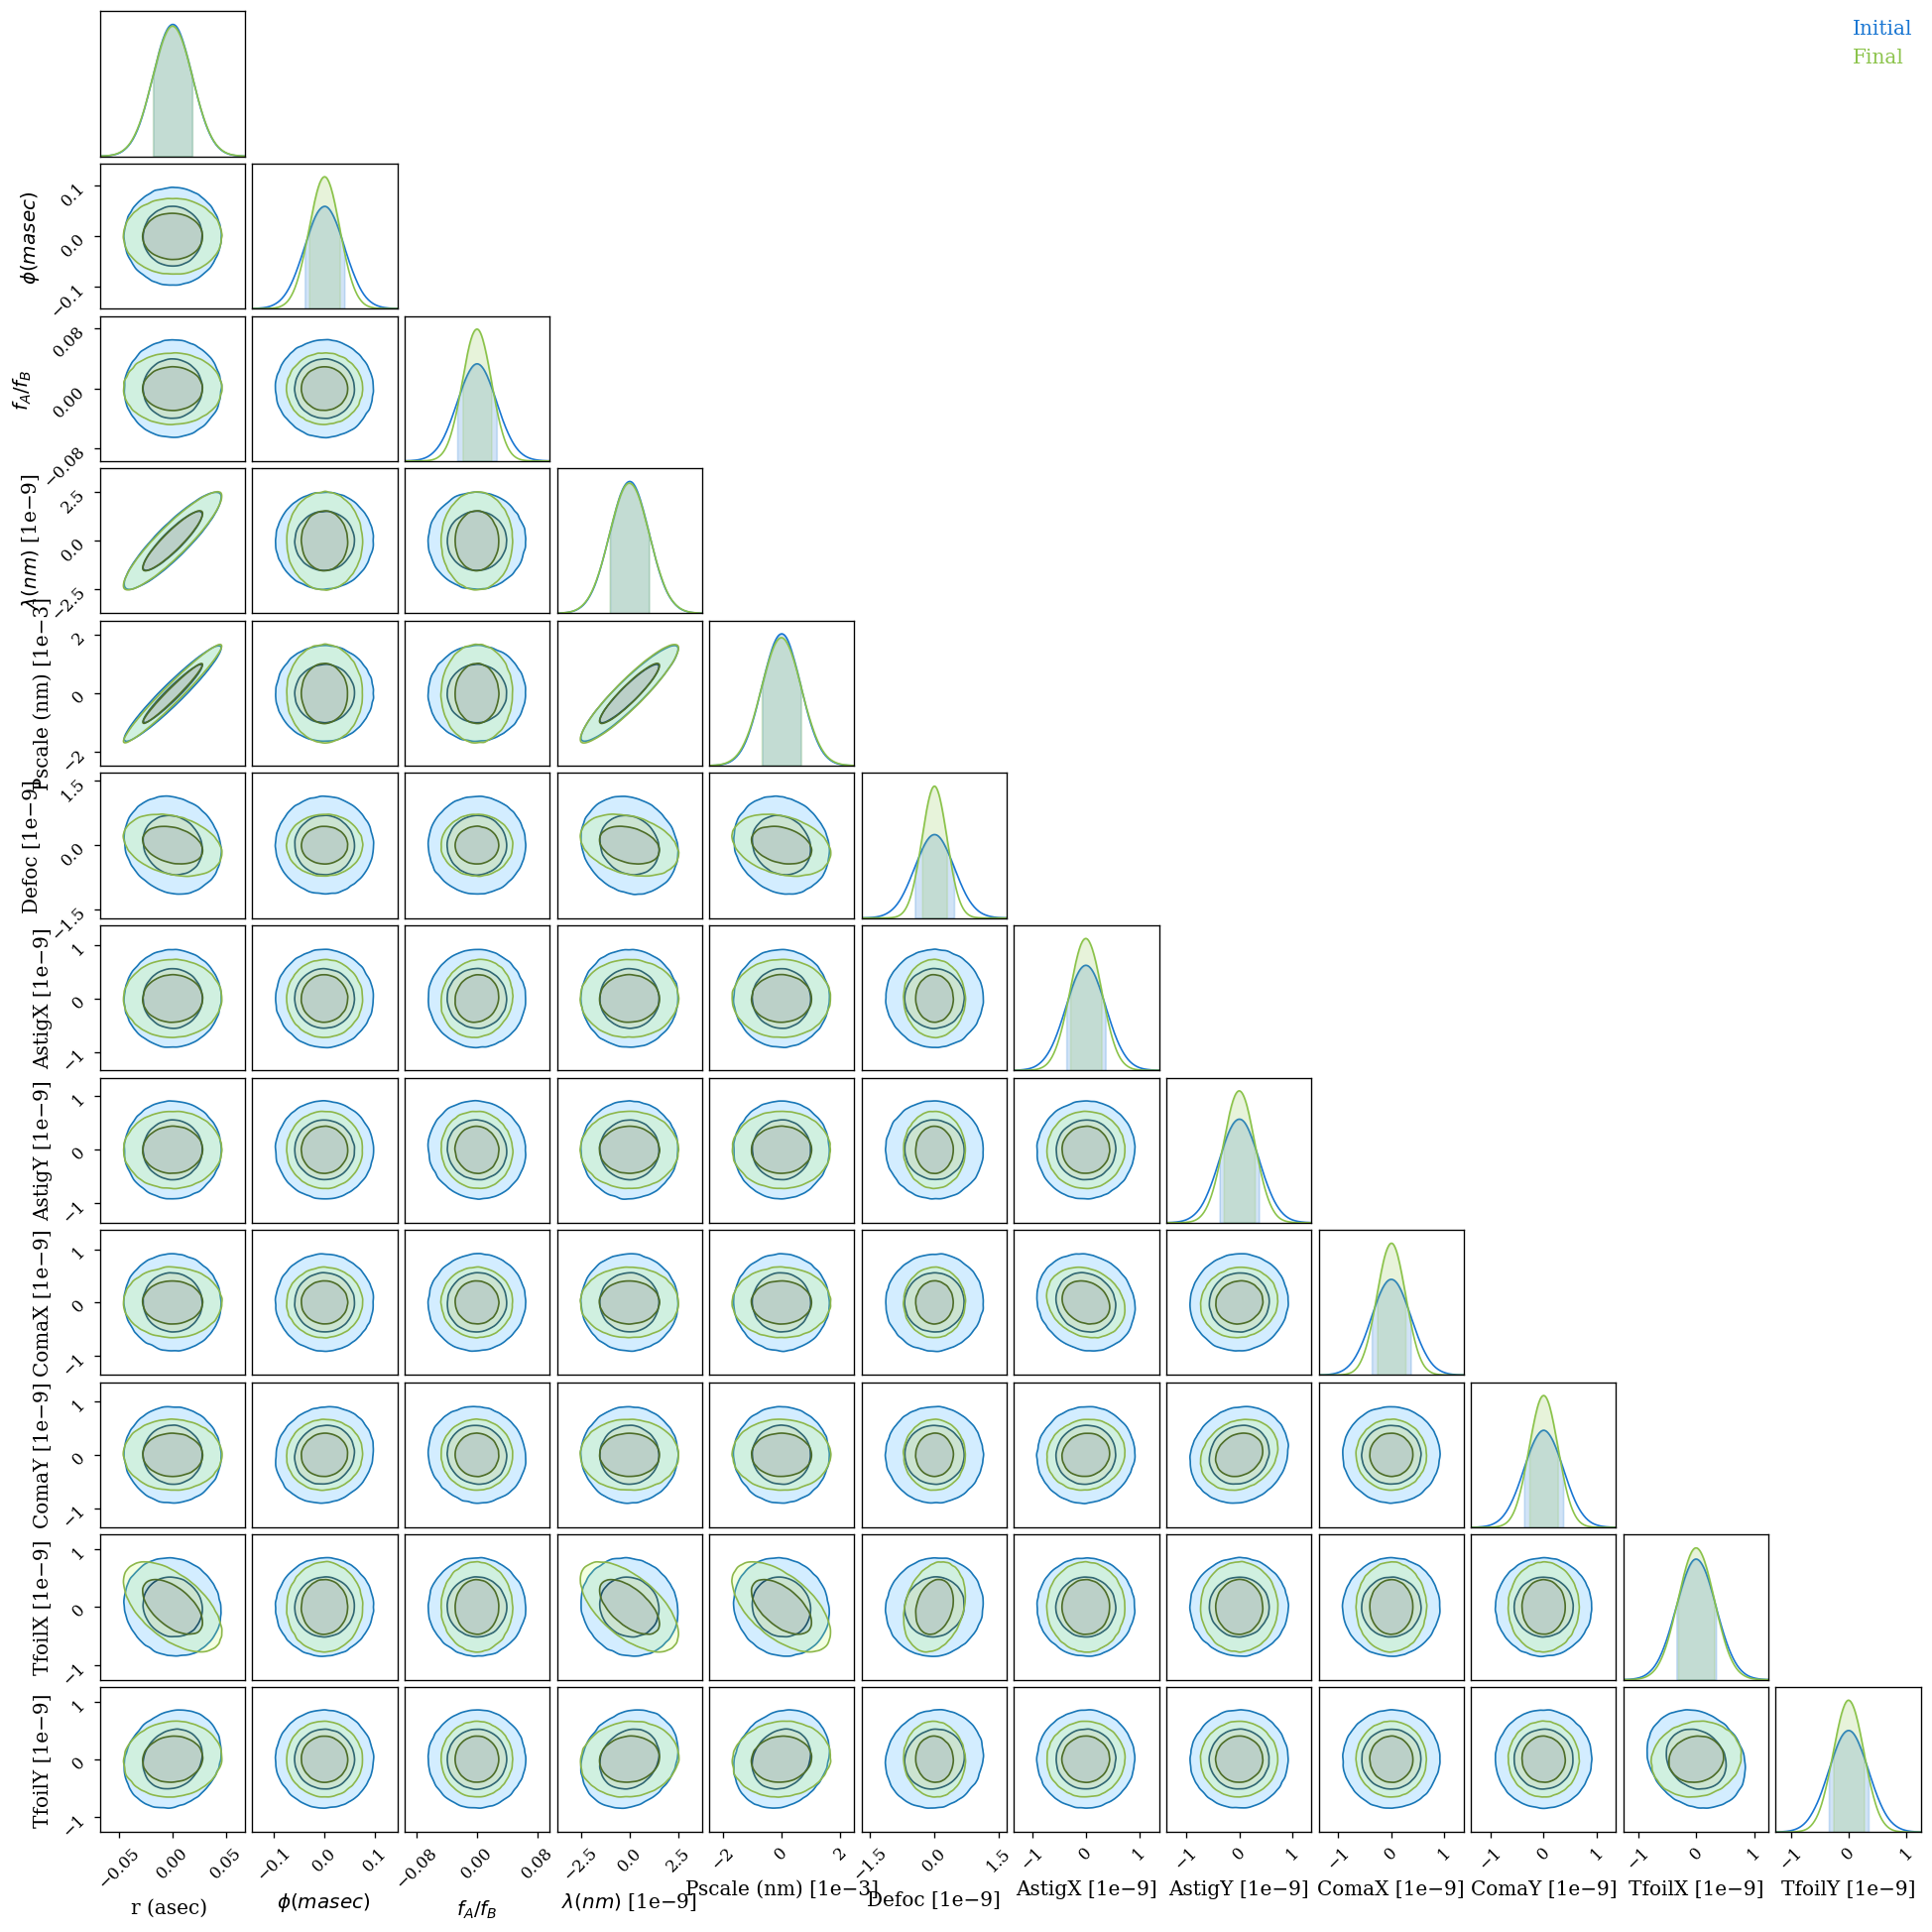

In [13]:
param_names = ["r (asec)", "$\phi (masec)$", '$f_A/f_B$', "$\lambda (nm)$",
               "Pscale (nm)", "Defoc", "AstigX", "AstigY", "ComaX", "ComaY",
               "TfoilX", "TfoilY"]
X = np.zeros(len(param_names))
c = ChainConsumer()
c.add_covariance(X, covs[0], parameters=param_names, name='Initial')
c.add_covariance(X, covs[1], parameters=param_names, name='Final')
c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

# fig = c.plotter.plot_summary() # currently bugged for \phi - issue raised
fig = c.plotter.plot()

It looks like the optimization worked - marginal posterior bounds for all the optical parameters are *much* tighter after the optimization than they were before.

We see that in this narrowband simulation, most parameters aren't tightly correlated, but separation, plate scale and wavelength are almost indistinguishable - this makes sense, as they affect the PSF in the same way! Only independent constraints on λ can save us here. If you want to do precise astrometry, you have to nail down your plate scale and your spectrum: we see that the marginal posterior for separation is the same, but dominated entirely by this degeneracy with plate scale and λ, which is much tighter for the optimized pupil.

This is why in the Toliman telescope design we superimpose a grating over our pupil \([design paper, Fig 6](https://authors.library.caltech.edu/92050/1/107011J.pdf)\) - so we can measure a stellar spectrum and separate this from the astrometry.

If we were doing this properly for a telescope design, we would want to take this into account - our real goal is precisely measuring separation, and everything else is something we can just marginalize over. If we incorporate our prior constraints on plate scale and wavelength I am sure we will do even better.